In [43]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_ind,ttest_rel
from scipy import stats,signal
import matplotlib.pyplot as plt

import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import platform
import os
import pandas as pd

import imageio

import fig3_helper_functions

# add the top level directory to allow it to be imported
import sys
sys.path.append(os.path.split(os.getcwd())[0])
from utilities import plotting_utilities

from visual_behavior_research.projects.tbd.session import Session

import visual_behavior_research.projects.tbd.utilities as tbdu
from visual_behavior_research.projects.tbd.Inscopix.series import SeriesCellSet
import visual_behavior_research.plotting as vbp
import visual_behavior_research.plotting.dro_plots as pf
import visual_behavior_research.utilities as vbu

from visual_behavior_research.projects.tbd.identify_repeat_rois import Repeat_ROI_Identifier

import isx
from visual_behavior_research.projects.tbd.Inscopix.pipeline import make_cell_map,plot_cell_map

from visual_behavior.translator.foraging import data_to_change_detection_core
from visual_behavior.translator.core import create_extended_dataframe

import fig3_helper_functions

pd.set_option('display.max_columns', 500)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
data_summary = tbdu.get_data_inventory()
data_summary.head()

,id,basepath,behavior_stage,folder,genotype,good_behavior,good_for_analysis,good_neural_data,good_sync,manually_checked,mouse_id,notes,problem,problem_description,processed,running_data,verified_files_present,size(gb),experiment_type,single_cell_plots_made,single_cell_images_made,number_accepted_cells,full_path,recording_date,processing_date,summarized
0,0,//olsenlab1/data/endoscope_imaging,autoreward,2018.03.07_M332849_DoC_day1_autoreward,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,yes,0,M332849,None,1,Not organized into 10 minute chunks,0.0,yes,None,74.790761,change_detection,None,None,NaN,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-07 15:16:45.876000,2018-12-15 15:53:28.984200001-08:00,None
1,1,//olsenlab1/data/endoscope_imaging,static_grating,2018.03.09_M332849_DoC_day2,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,no,no,yes,yes,1,M332849,None,0,None,1.0,yes,None,151.789864,change_detection,True,True,45.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-09 11:27:50.579000,2018-07-25 12:41:22.762362242-07:00,True
2,2,//olsenlab1/data/endoscope_imaging,static_grating,2018.03.13_M332849_DoC_day4,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,yes,1,M332849,None,0,None,1.0,yes,None,134.175156,change_detection,True,True,64.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-13 11:26:45.003000,2018-07-20 10:57:53.647888899-07:00,True
3,3,//olsenlab1/data/endoscope_imaging,natural_images,2018.03.30_M332849_DoC_day9,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,yes,1,M332849,None,0,Note: more dead cells in forcus this day,1.0,yes,None,146.164498,change_detection,True,True,57.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-30 13:53:41.511000,2018-07-25 13:48:01.009045124-07:00,True
4,4,//olsenlab1/data/endoscope_imaging,natural_images,2018.04.3_M332849_DoC_day11,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,no,no,yes,no,1,M332849,None,0,None,1.0,yes,None,144.396109,change_detection,True,True,108.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-04-03 13:20:29.101000,2018-07-25 13:59:23.514958143-07:00,True


In [19]:
last_sessions = pd.DataFrame(data_summary.query('good_for_analysis == "yes"').groupby('mouse_id')['recording_date'].max()).reset_index() # last session for every mouse
sessions_to_analyze = last_sessions.merge(
    data_summary,
    left_on=['mouse_id','recording_date'],
    right_on=['mouse_id','recording_date'],
)
sessions_to_analyze

,mouse_id,recording_date,id,basepath,behavior_stage,folder,genotype,good_behavior,good_for_analysis,good_neural_data,good_sync,manually_checked,notes,problem,problem_description,processed,running_data,verified_files_present,size(gb),experiment_type,single_cell_plots_made,single_cell_images_made,number_accepted_cells,full_path,processing_date,summarized
0,M332849,2018-06-14 12:44:33.658000,12,//olsenlab1/data/endoscope_imaging,natural_images,2018.06.14_M332849_DoC_day23,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,no,1,None,0,None,1.0,yes,None,146.340312,change_detection,True,True,126.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-07-26 12:11:01.983524799-07:00,True
1,M348126,2018-06-13 13:47:38.463000,29,//olsenlab1/data/endoscope_imaging,natural_images,2018.06.13_M348126_DoC_Day20,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,yes,yes,yes,no,1,None,0,None,1.0,yes,None,147.288604,change_detection,True,True,103.0,//olsenlab1/data/endoscope_imaging/M348126/201...,2018-07-26 18:15:45.828682184-07:00,True
2,M351181,2018-03-14 14:32:15.328000,37,//olsenlab1/data/endoscope_imaging,natural_images,2018.03.14__M351181_DoC_day8,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,yes,yes,yes,yes,1,None,0,None,1.0,yes,None,147.362931,change_detection,True,True,127.0,//olsenlab1/data/endoscope_imaging/M351181/201...,2018-07-26 18:59:36.293976068-07:00,True
3,M397408,2018-11-01 11:40:14.487000,153,//olsenlab1/data/endoscope_imaging,None,20181101_M397408_DoC_day5,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,None,yes,None,None,0,,0,,1.0,None,None,153.154207,change_detection,True,True,29.0,//olsenlab1/data/endoscope_imaging/M397408/201...,2019-01-22 01:32:10.700291872-08:00,True
4,M423780,2019-06-11 10:38:31,245,//olsenlab1/data/endoscope_imaging,None,2019.06.11_DoC,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,None,yes,None,None,None,None,0,,1.0,None,None,183.495635,change_detection,True,True,61.0,//olsenlab1/data/endoscope_imaging/M423780/201...,2019-06-26 23:56:50.550086260-07:00,True


In [17]:
data = {}

folders = sessions_to_analyze['folder']

for foldername in folders:
    print('on folder {}'.format(foldername))

    row = data_summary[data_summary['folder']==foldername].iloc[0]

    mouse_id = row['mouse_id']
    path = os.path.join(row['basepath'],row['mouse_id'],row['folder'])

    data[foldername]=pd.read_pickle(os.path.join(path,'cached_data_2019.10.04.pkl'))

    data[foldername]['session'] = Session(
        data[foldername]['path'], 
        load_cached_traces_table = True,
        behavior_pkl_filename = fig3_helper_functions.which_pkl(data[foldername]['filename_dict'])
    )

on folder 2018.06.14_M332849_DoC_day23
filename = //olsenlab1/data/endoscope_imaging/M332849/2018.06.14_M332849_DoC_day23/additional_data/180614134458-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_drop_reward_mouse=M332849.pkl
on folder 2018.06.13_M348126_DoC_Day20
filename = //olsenlab1/data/endoscope_imaging/M348126/2018.06.13_M348126_DoC_Day20/additional_data/180613144805-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_drop_reward_mouse=M348126.pkl
on folder 2018.03.14__M351181_DoC_day8
filename = //olsenlab1/data/endoscope_imaging/M351181/2018.03.14__M351181_DoC_day8/additional_data/180314153237-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_drop_reward_mouse=M351181.pkl
on folder 20181101_M397408_DoC_day5
filename = //olsenlab1/data/endoscope_imaging/M397408/20181101_M397408_DoC_day5/additional_data/181101124039-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_mouse=M397408.pkl
on folder 2019.06.11_DoC
filename = //olsenlab1/data/endos

In [40]:
foldernames = list(data.keys())
for i,foldername in enumerate(foldernames):
    print(i,foldername)

0 2018.06.14_M332849_DoC_day23
1 2018.06.13_M348126_DoC_Day20
2 2018.03.14__M351181_DoC_day8
3 20181101_M397408_DoC_day5
4 2019.06.11_DoC


In [41]:
mice = data_summary[data_summary.good_for_analysis=='yes'].mouse_id.unique()
mice

array(['M332849', 'M348126', 'M351181', 'M397408', 'M423780'],
      dtype=object)

## build out responsiveness summary

In [46]:
frame_before=200
frame_after=200

cell_lookup = []

event_types = ['hit','miss','fa','cr']
    
mean_response_dfs = {event_type:pd.DataFrame({'t':np.linspace(-frame_before*0.05,(frame_after-1)*0.05,frame_before+frame_after)}) for event_type in event_types}

responsiveness_summary_all = []
for ii,foldername in enumerate(foldernames):
    print('on {} of {}'.format(ii,len(foldernames)))
    mouse_id = data_summary[data_summary['folder']==foldername].mouse_id.iloc[0]

    data_dict = data[foldername]
    session = data_dict['session']
    trials = session.behavior_core_data['extended_trials']
    traces_zs = session.filtered_traces

    rewards = data_dict['core_data']['rewards']

    licks = data_dict['core_data']['licks']
    licks['nearest_F_frame'] = licks['frame'].map(lambda x:fig3_helper_functions.get_F_frame(int(x),data_dict['sync_data']))
    licks['time_since_last_lick'] = licks['time'] - licks['time'].shift()
    licks['nearest_reward']=licks['time'].map(lambda x:fig3_helper_functions.nearest_reward(x,rewards))

    vs = data_dict['core_data']['visual_stimuli']
    vs['nearest_lick'] = vs['time'].map(lambda x:fig3_helper_functions.nearest_lick(x,licks))
    vs['change'] = vs['image_name'] != vs['image_name'].shift()
    vs['nearest_F_frame'] = vs['frame'].map(lambda x:fig3_helper_functions.get_F_frame(int(x),data_dict['sync_data']))

    data_dict['hit_events'] = licks[
        (licks['nearest_reward']<0.1)
        &(licks['time_since_last_lick']>2.25)
        &(~np.isnan(licks['nearest_F_frame']))
    ]['nearest_F_frame']

    data_dict['fa_events'] = licks[
        (licks['nearest_reward']>2)
        &(licks['time_since_last_lick']>2.25)
        &(~np.isnan(licks['nearest_F_frame']))
    ]['nearest_F_frame']

    data_dict['miss_events'] = trials.query('response_type == "MISS"')['change_frame'].map(lambda x:fig3_helper_functions.get_F_frame(int(x),data_dict['sync_data']))
    data_dict['miss_events'] = data_dict['miss_events'][pd.notnull(data_dict['miss_events'])]

    cr_events = vs.query('change == False and nearest_lick > 2')
    data_dict['cr_events'] = cr_events.sample(min(100,len(cr_events)),random_state=0)['nearest_F_frame'] #get a random sample of correct rejections (non-change flashes without nearby licks)
    data_dict['cr_events'] = data_dict['cr_events'][pd.notnull(data_dict['cr_events'])]

    data_dict['responsiveness_data'] = fig3_helper_functions.get_responsiveness_data(data_dict,foldername)
    data_dict['responsiveness_summary'] = fig3_helper_functions.build_responsiveness_summary(data_dict['responsiveness_data'])
    responsiveness_summary_all.append(data_dict['responsiveness_summary'])

    # build out datatframes containiing mean resonses for every cell and every event type
    for cell_id in session.filtered_cell_IDs:
        for condition in ['hit','miss','fa','cr']:
            events = data_dict['{}_events'.format(condition)]
            dat = fig3_helper_functions.get_responses(session,cell_id,events,frame_before=frame_before,frame_after=frame_after)
            mean_response_dfs[condition]['{}_{}'.format(foldername,cell_id)] = dat['trace_mean']

#     print('failed on {}'.format(foldername))
#     print('e')
responsiveness_summary_all = pd.concat(responsiveness_summary_all)
responsiveness_summary_all['integral_change_magnitude'] = responsiveness_summary_all['post_stim_integral_mean'] - responsiveness_summary_all['pre_stim_integral_mean']
responsiveness_summary_all['mean_change_magnitude'] = responsiveness_summary_all['post_stim_mean_all'] - responsiveness_summary_all['pre_stim_mean_all']

on 0 of 5
on 1 of 5
on 2 of 5
on 3 of 5
on 4 of 5


In [47]:
responsiveness_summary_all

,cell_id,foldername,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,integral_change_magnitude,mean_change_magnitude
0,C000,2018.06.14_M332849_DoC_day23,hit,52,0.848459,-13.264108,1.656468e-59,-1.0,0.041064,-0.703737,2.712022e-61,-1.0,-14.112567,-0.744800
1,C000,2018.06.14_M332849_DoC_day23,miss,67,0.397386,0.415719,9.056278e-01,1.0,0.023364,0.024934,8.460343e-01,1.0,0.018333,0.001570
2,C000,2018.06.14_M332849_DoC_day23,fa,194,0.437994,0.968092,2.761449e-01,1.0,0.024784,0.052512,2.593075e-01,1.0,0.530098,0.027728
3,C000,2018.06.14_M332849_DoC_day23,cr,71,-0.305738,0.385686,9.471378e-01,1.0,-0.015864,0.021891,9.262473e-01,1.0,0.691424,0.037755
4,C001,2018.06.14_M332849_DoC_day23,hit,52,-1.166445,-1.232684,3.234759e-01,-1.0,-0.060219,-0.063337,3.222675e-01,-1.0,-0.066238,-0.003118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,C169,2019.06.11_DoC,cr,100,0.662356,0.151812,2.043036e-01,-1.0,0.036243,0.009318,2.271388e-01,-1.0,-0.510544,-0.026925
240,C173,2019.06.11_DoC,hit,65,1.566781,6.903325,3.254444e-17,1.0,0.085906,0.356864,4.687726e-17,1.0,5.336544,0.270957
241,C173,2019.06.11_DoC,miss,183,0.048756,0.304185,3.224942e-01,1.0,0.001494,0.015361,2.866519e-01,1.0,0.255428,0.013868
242,C173,2019.06.11_DoC,fa,272,1.566877,-0.806899,1.182296e-04,-1.0,0.083202,-0.040309,1.209917e-04,-1.0,-2.373776,-0.123510


## plot responsiveness histograms

In [57]:
def plot_mod_index_hist(index_vals, significant, ax, bin_edges=np.arange(-1,1,0.05)):
    '''
    index_vals (array of float): values of the index you want to plot
    significant (array of bool): whether each index val is significant or not
    '''
    
    ax.hist([index_vals[significant],index_vals[~significant]], 
             color=['k','darkgrey'], edgecolor='None', stacked=True, 
             bins=bin_edges, rwidth=0.8, normed=True)


def plot_response_histograms(ax=None, significance_threshold=0.05):
    '''
    ax should be a 1x4 array of axis handles if passed
    '''
    if ax is None:
        fig,ax=plt.subplots(1,4,figsize=(14,2),sharex=True, sharey=False)
        
    titles = ['Hits','False Alarms','Misses','Correct Rejects']
    for ii,condition in enumerate(['hit','fa','miss','cr']):
        magnitude = responsiveness_summary_all.query('condition == @condition')['mean_change_magnitude']
        significant = responsiveness_summary_all.query('condition == @condition')['p-value_on_means'] < significance_threshold
        plot_mod_index_hist(
            magnitude,
            significant,
            ax[ii]
        )

        axins = inset_axes(ax[ii], width="40%", height="40%", loc=1)

        ax[ii].set_title('{}\nfraction modulated cells: {:0.3f}'.format(titles[ii],significant.mean()))

    #     ax[ii].axvline(0,linestyle=':',color='k',)
        axins.pie(
            [significant.sum(),len(significant)-significant.sum()],
            colors=['black','gray'],
            labels=['','']
        )
        ax[ii].set_xlabel('change in mean (z-score)')
        ax[ii].set_yticks([])
    ax[0].set_ylabel('fraction')
    sns.despine()

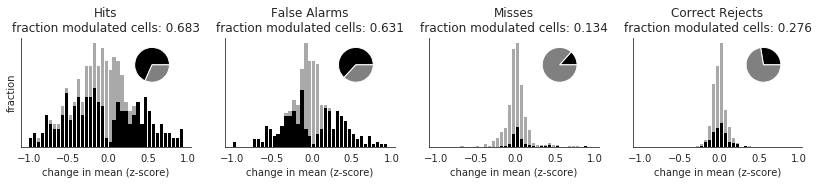

In [58]:
plot_response_histograms(ax=None, significance_threshold=0.05)

## plot response heatmaps

In [73]:
def plot_heatmaps(ax=None, order_by_hits=False):
    if ax is None:
        fig,ax=plt.subplots(1,4,figsize=(12,5))

    tmin = mean_response_dfs['hit']['t'].min()
    tmax = mean_response_dfs['hit']['t'].max()

    titles = ['Hits','Misses','False Alarms','Correct Rejects']
    for ii,event_type in enumerate(event_types):
        idx_for_mean = mean_response_dfs[event_type][['t']].query('t>0 and t<1').index
        if order_by_hits == False:
            col_order = mean_response_dfs[event_type].drop(columns=['t']).loc[idx_for_mean].mean(axis=0).dropna().sort_values(ascending=False).index
        else:
            col_order = mean_response_dfs['hit'].drop(columns=['t']).loc[idx_for_mean].mean(axis=0).dropna().sort_values(ascending=False).index  
        arr = mean_response_dfs[event_type][col_order].values

        ax[ii].imshow(
            arr.T,
            clim=[-1.5,1.5],
            cmap='seismic',
            aspect='auto',
            extent=(tmin,tmax,0,len(col_order)),
            interpolation='none'
        )

        ax[ii].set_title(titles[ii])
        ax[ii].set_yticks([])
        ax[ii].set_xticks([0,2,4])
        ax[ii].set_xlabel('time from\nevent (s)')
        ax[ii].axvline(0,color='black',alpha=0.5,linewidth=3)

        ax[ii].set_xlim(-1,5)

      

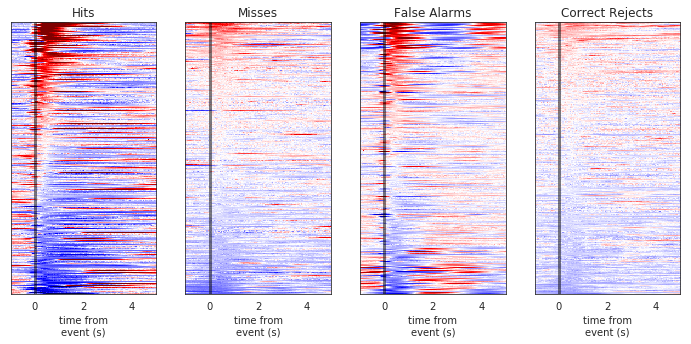

In [74]:
plot_heatmaps(ax=None, order_by_hits=False)

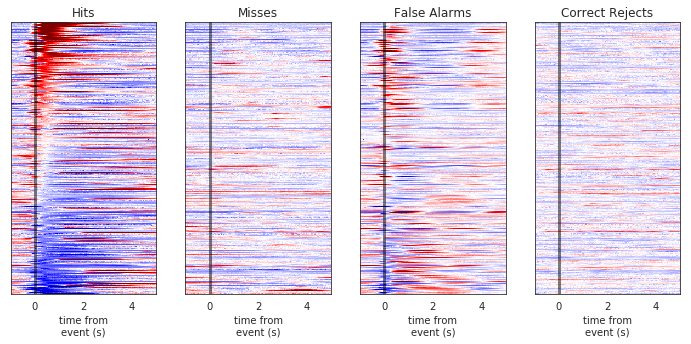

In [75]:
plot_heatmaps(ax=None, order_by_hits=True)

## plot example cells

In [102]:
factilitated = responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'hit')
    &(responsiveness_summary_all['p-value_on_means'] < 0.001)
    &(abs(responsiveness_summary_all['post_stim_mean_all']) > 0.75)
    &(abs(responsiveness_summary_all['pre_stim_mean_all']) < 0.15)
    &(responsiveness_summary_all['direction_of_effect_on_means'] > 0)
][['foldername','cell_id']].reset_index()
factilitated.head()

,index,foldername,cell_id
0,52,2018.06.14_M332849_DoC_day23,C013
1,100,2018.06.14_M332849_DoC_day23,C025
2,108,2018.06.14_M332849_DoC_day23,C029
3,156,2018.06.14_M332849_DoC_day23,C043
4,388,2018.06.14_M332849_DoC_day23,C123


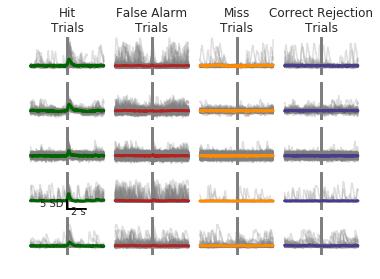

In [124]:
to_plot = factilitated.sample(5,random_state=2)
fig,ax=plt.subplots(len(to_plot),4,figsize=(6,4),sharex=True,sharey=True)

fig3_helper_functions.plot_examples(to_plot, data, ax)

In [105]:
suppressed = responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'hit')
    &(responsiveness_summary_all['p-value_on_means'] < 0.001)
    &(abs(responsiveness_summary_all['post_stim_mean_all']) < 0.5)
    &(abs(responsiveness_summary_all['pre_stim_mean_all']) > 0.25)
    &(responsiveness_summary_all['direction_of_effect_on_means'] < 0)
][['foldername','cell_id']].reset_index()
suppressed.head()

,index,foldername,cell_id
0,192,2018.06.14_M332849_DoC_day23,C059
1,276,2018.06.14_M332849_DoC_day23,C088
2,356,2018.06.14_M332849_DoC_day23,C111
3,120,2018.06.13_M348126_DoC_Day20,C034
4,224,2018.06.13_M348126_DoC_Day20,C065


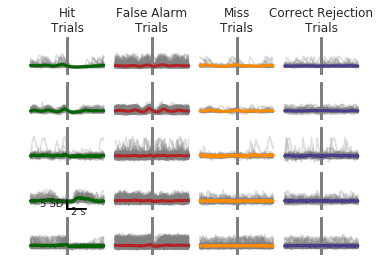

In [125]:
to_plot = suppressed.sample(5, random_state=1)
fig,ax=plt.subplots(len(to_plot),4,figsize=(6,4),sharex=True,sharey=True)
fig3_helper_functions.plot_examples(to_plot, data, ax)

## show schematics

In [27]:
def show_schematic(filename, ax=None,):
    if ax is None:
        fig,ax=plt.subplots()
    image = imageio.imread(filename)
    ax.imshow(image,interpolation='nearest')
    ax.axis('off')

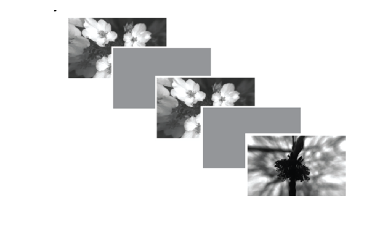

In [28]:
show_schematic('flashing_image_schematic.png')

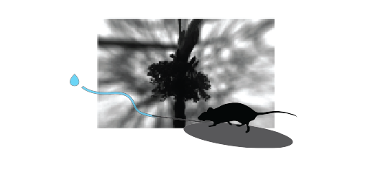

In [29]:
show_schematic('mouse_schematic.png')

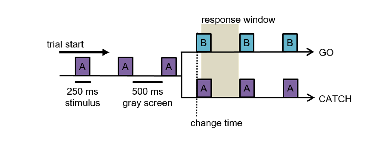

In [30]:
show_schematic('task_schematic.png')

In [130]:
47-5

42

In [132]:
100-53

47

# Final Figure

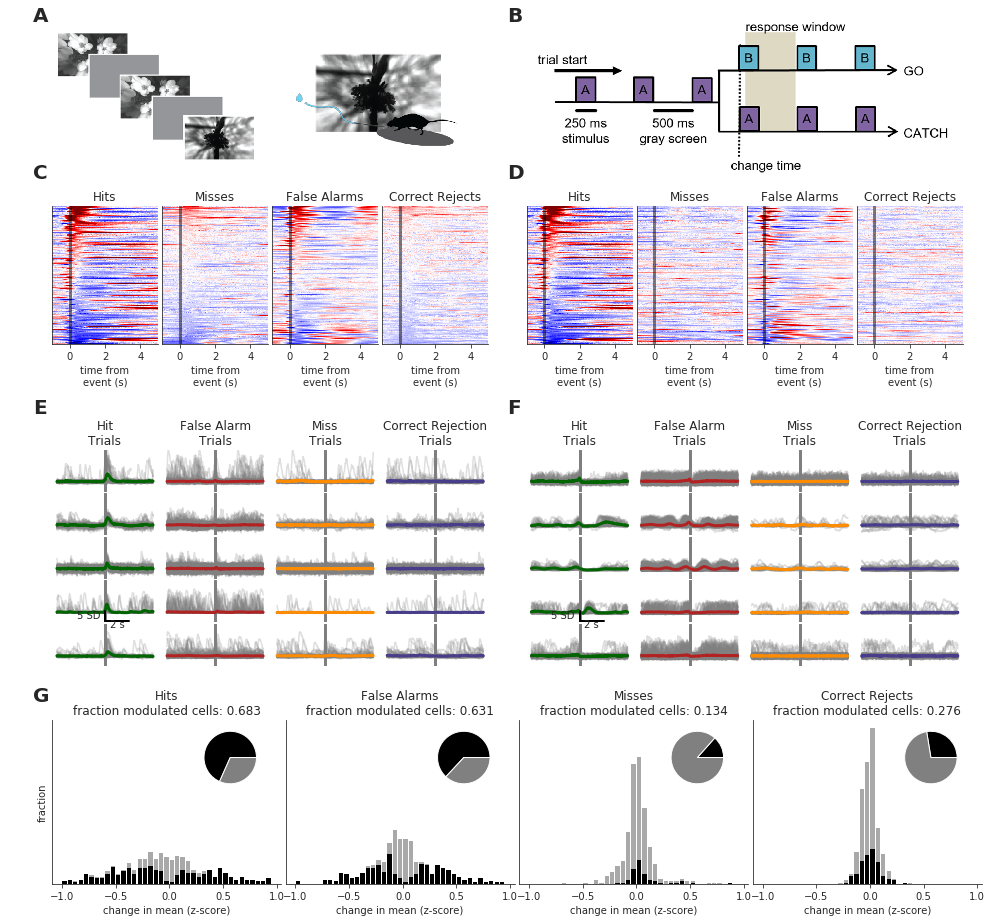

In [135]:
save_fig = True

figsize=(2*8.5,2*8)
figure_3 = plt.figure(figsize=figsize)
n_example_cells = 5
axes = {
    'A1':plotting_utilities.placeAxesOnGrid(figure_3, xspan=[0.0,0.25], yspan=[0,0.2]),
    'A2':plotting_utilities.placeAxesOnGrid(figure_3, xspan=[0.25,0.5], yspan=[0,0.2]),
    'B':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.5,1],    yspan=[0,0.2]),
    'C':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.02,0.48],   yspan=[0.22,0.38], dim=[1,4], sharex=True, sharey=True, wspace=0.04),
    'D':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.52,0.98],   yspan=[0.22,0.38], dim=[1,4], sharex=True, sharey=True, wspace=0.04),
    'E':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.02,0.48],   yspan=[0.5,0.75], dim=[n_example_cells,4], sharex=False, sharey=True, wspace=0.04, hspace=0.04),
    'F':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.52,0.98],   yspan=[0.5,0.75], dim=[n_example_cells,4], sharex=False, sharey=True, wspace=0.04, hspace=0.04),
    'G':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.02,1],   yspan=[0.81,1],    dim=[1,4], sharex=True, sharey=True, wspace=0.02),
}
    
show_schematic('flashing_image_schematic.png', ax=axes['A1'])
show_schematic('mouse_schematic.png', ax=axes['A2'])
show_schematic('task_schematic.png', ax=axes['B'])

plot_heatmaps(ax=axes['C'], order_by_hits=False)
plot_heatmaps(ax=axes['D'], order_by_hits=True)

fig3_helper_functions.plot_examples(factilitated.sample(5,random_state=2), data, ax=axes['E'])
fig3_helper_functions.plot_examples(suppressed.sample(5,random_state=2), data, ax=axes['F'])

plot_response_histograms(ax=axes['G'], significance_threshold=0.05)

# add labels
labels = [
    {'label_text':'A', 'xpos':0,   'ypos':0.0},
    {'label_text':'B', 'xpos':0.5, 'ypos':0.0},
    {'label_text':'C', 'xpos':0,   'ypos':0.18},
    {'label_text':'D', 'xpos':0.5, 'ypos':0.18},
    {'label_text':'E', 'xpos':0,   'ypos':0.45},
    {'label_text':'F', 'xpos':0.5, 'ypos':0.45},
    {'label_text':'G', 'xpos':0,   'ypos':0.78},
]
for label in labels:
    plotting_utilities.add_label(
        figure_3,
        label_text = label['label_text'],
        xpos = label['xpos'],
        ypos = label['ypos'],
        fontsize=20,
        weight="bold"
    )

if save_fig:
    plotting_utilities.save_figure(figure_3, fname='figure_3', formats=['.png','.pdf'], size=figsize, dpi=500)